In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset
from dataclasses import dataclass
import matplotlib.pyplot as plt
import seaborn as sns

# from DynGenModels.datamodules.gaia.dataprocess import PreProcessGaiaData

class GaiaDataset(Dataset):

    def __init__(self, dataset, cuts, preprocess=['standardize']):
        
        self.dataset = dataset
        self.cuts = cuts
        self.preprocess_methods = preprocess 
        self.summary_stats = None
        
        ''' datasets:
            target data (t=1) :  fermi galaxy data
            source data (t=0) :  std gaussian
        '''

        self.target_preprocess = self.get_target_data()
        self.source_preprocess = self.get_source_data()

    def __getitem__(self, idx):
        output = {}
        output['target'] = self.target_preprocess[idx]
        output['source'] = self.source_preprocess[idx]
        return output

    def __len__(self):
        return self.target_preprocess.size(0)
    
    def __iter__(self):
        for i in range(len(self)):
            yield self[i]

    def get_target_data(self):
        target = torch.tensor(np.load(self.dataset[0]), dtype=torch.float32)        
        # target = PreProcessGaiaData(target, cuts=self.cuts, methods=self.preprocess_methods)
        # target.apply_cuts()
        self.target = target
        # target.preprocess()
        # self.summary_stats = target.summary_stats
        return self.target 

    def get_covariance_data(self):
        covariance = torch.tensor(np.load(self.dataset), dtype=torch.float32)

    def get_source_data(self):
        self.source = torch.randn_like(self.target, dtype=torch.float32)
        return self.source


class PreProcessGaiaData:

    def __init__(self, 
                 data, 
                 cuts: dict={'r': None},
                 methods: list=['standardize']
                 ):
        
        self.features = data
        self.cuts = cuts 
        self.methods = methods
        self.summary_stats = {}

    def apply_cuts(self, sun: list=[8.122, 0.0, 0.0208]):
        ''' center sun in origin and apply radial cut at a few kiloparsec
        '''
        x = self.features[..., 0] - sun[0]
        y = self.features[..., 1] - sun[1]
        z = self.features[..., 2] - sun[2]
        r = torch.sqrt(x**2 + y**2 + z**2)
        mask = (r >= self.cuts['r']) & (r <= self.cuts['r'])
        self.features = self.features[mask]

    def preprocess(self):        
        #...preprocess with provided methods
        for method in self.methods:
            method = getattr(self, method, None)
            if method and callable(method): method()
            else: raise ValueError('Preprocessing method {} not implemented'.format(method))
    

    def standardize(self,  sigma: float=1.0):
        """ standardize data to have zero mean and unit variance
        """
        self.summary_stats['mean'] = torch.mean(self.features, dim=0)
        self.summary_stats['std'] = torch.std(self.features, dim=0)
        self.features = (self.features - self.summary_stats['mean']) * (sigma / self.summary_stats['std'])

    def normalize(self):
        """ normalize data to unit interval
        """
        self.summary_stats['min'], _ = torch.min(self.features[..., :3], dim=0)
        self.summary_stats['max'], _ = torch.max(self.features[..., :3], dim=0)
        self.features[..., :3] = (self.features[..., :3] - self.summary_stats['min']) / ( self.summary_stats['max'] - self.summary_stats['min'])
    
    def logit_transform(self, alpha=1e-5):
        """ smoothen rectified distribution with logit transform
        """
        self.features[..., :3] = self.features[..., :3] * (1 - 2 * alpha) + alpha
        self.features[..., :3] = torch.log(self.features[..., :3] / (1 - self.features[..., :3]))



class PostProcessGaiaData:

    def __init__(self, 
                 data, 
                 summary_stats,
                 methods: list=['inverse_standardize']
                 ):
        
        self.features = data
        self.summary_stats = summary_stats
        self.methods = methods

    def postprocess(self):
        for method in self.methods:
            method = getattr(self, method, None)
            if method and callable(method): method()
            else: raise ValueError('Postprocessing method {} not implemented'.format(method))

    def inverse_standardize(self,  sigma: float=1.0):
        self.features = self.features * (self.summary_stats['std'] / sigma) + self.summary_stats['mean']

    def inverse_normalize(self):
        self.features[..., :3] = self.features[..., :3] * (self.summary_stats['max'] - self.summary_stats['min']) + self.summary_stats['min']
    
    def inverse_logit_transform(self, alpha=1e-5):
        exp = torch.exp(self.features)
        self.features[..., :3] = exp / (1 + exp)
        self.features[..., :3] = (self.features[..., :3] - alpha) / (1 - 2 * alpha)


In [2]:
dat = ['../data/gaia/data.angle_340.smeared_00.npy', 
       '../data/gaia/data.angle_340.smeared_00.cov.npy']

dataset =  GaiaDataset(dat, cuts={'r': 3.5}, preprocess=['standardize'])

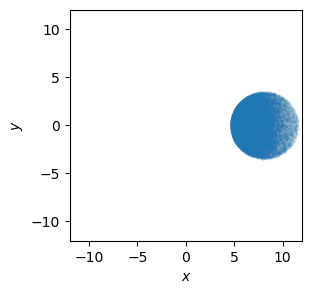

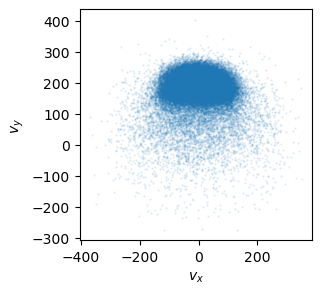

In [13]:
#plot gaia data
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.scatter(dataset.target_preprocess[:50000, 0], dataset.target_preprocess[:50000, 1], s=0.1, alpha=0.1)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_xlim(-12, 12)
ax.set_ylim(-12, 12)
plt.show()

#plot gaia data
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.scatter(dataset.target_preprocess[:50000, 3], dataset.target_preprocess[:50000, 4], s=0.5, alpha=0.1)
ax.set_xlabel(r'$v_x$')
ax.set_ylabel(r'$v_y$')
# ax.set_xlim(3, 12)
# ax.set_ylim(-5, 5)
plt.show()